<a href="https://colab.research.google.com/github/Fazlibeqir/Timski-Proekt/blob/main/YOLO8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -U gdown

In [ ]:
import pandas as pd
import shutil
import os
import requests
import time
from sklearn.model_selection import train_test_split

id= 1YIWUosBhUGehy98KkTtW76hcIh5Hh6Si

In [ ]:
!gdown --id 1YIWUosBhUGehy98KkTtW76hcIh5Hh6Si

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1YIWUosBhUGehy98KkTtW76hcIh5Hh6Si
From (redirected): https://drive.google.com/uc?id=1YIWUosBhUGehy98KkTtW76hcIh5Hh6Si&confirm=t&uuid=4b5df3ee-6741-4428-9339-427e3cd275ee
To: /content/0044847-241126133413365.csv
100% 243M/243M [00:02<00:00, 94.6MB/s]


In [ ]:
# Config
csv_path = "/content/0044847-241126133413365.csv"
dataset_dir = "dataset"
train_dir = os.path.join(dataset_dir, "train")
val_dir = os.path.join(dataset_dir, "val")
test_dir = os.path.join(dataset_dir, "test")
max_images_per_species = 100

In [ ]:
# Load CSV
df = pd.read_csv(csv_path, delimiter="\t")  # adjust delimiter if needed
species_list = df["scientificName"].dropna().unique()

# Create base folders
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

<ipython-input-8-6c6b30608413>:2: DtypeWarning: Columns (39,41) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path, delimiter="\t")  # adjust delimiter if needed


In [ ]:
def get_gbif_images(scientific_name, limit=200):
    url = "https://api.gbif.org/v1/occurrence/search"
    params = {
        "scientificName": scientific_name,
        "mediaType": "StillImage",
        "limit": limit
    }
    try:
        r = requests.get(url, params=params, timeout=10)
        if r.status_code != 200:
            print(f"[ERROR] Failed API request for {scientific_name}")
            return []
        results = r.json()
        images = []
        for record in results.get("results", []):
            for media in record.get("media", []):
                if media.get("identifier"):
                    images.append(media["identifier"])
        return images
    except Exception as e:
        print(f"[ERROR] Exception for {scientific_name}: {e}")
        return []

In [ ]:
def folder_has_enough_images(folder_path, min_count):
    return os.path.exists(folder_path) and len(os.listdir(folder_path)) >= min_count


def download_image(url, save_path):
    try:
        img_data = requests.get(url, timeout=10).content
        with open(save_path, "wb") as f:
            f.write(img_data)
        return True
    except Exception as e:
        print(f"Failed to download {url}: {e}")
        return False

In [ ]:
for species in species_list:
    print(f"\nProcessing species: {species}")

    species_folder_name = species.replace(" ", "_")

    # Create folders
    train_species_dir = os.path.join(train_dir, species_folder_name)
    val_species_dir = os.path.join(val_dir, species_folder_name)
    test_species_dir = os.path.join(test_dir, species_folder_name)
    if all([
        folder_has_enough_images(train_species_dir, int(max_images_per_species * 0.7)),
        folder_has_enough_images(val_species_dir, int(max_images_per_species * 0.15)),
        folder_has_enough_images(test_species_dir, int(max_images_per_species * 0.15))
    ]):
        print(f"[SKIP] {species} already has enough images. Skipping download.")
        continue

    os.makedirs(train_species_dir, exist_ok=True)
    os.makedirs(val_species_dir, exist_ok=True)
    os.makedirs(test_species_dir, exist_ok=True)

    # Get image URLs (fetch more to cover download failures)
    urls = get_gbif_images(species, limit=max_images_per_species * 3)
    if not urls:
        print(f"[SKIP] No images found for {species}. Removing empty folders.")
        shutil.rmtree(train_species_dir, ignore_errors=True)
        shutil.rmtree(val_species_dir, ignore_errors=True)
        shutil.rmtree(test_species_dir, ignore_errors=True)
        continue

    # Limit total images to max_images_per_species
    urls = urls[:max_images_per_species]

    # Split into train/val/test (70/15/15)
    if len(urls) < 3:
        print(f"[SKIP] Too few images to split for {species} (only {len(urls)}). Removing folders.")
        shutil.rmtree(train_species_dir, ignore_errors=True)
        shutil.rmtree(val_species_dir, ignore_errors=True)
        shutil.rmtree(test_species_dir, ignore_errors=True)
        continue

    train_urls, temp_urls = train_test_split(urls, test_size=0.3, random_state=42)

    if len(temp_urls) < 2:
        print(f"[SKIP] Not enough images for val/test for {species}. Removing folders.")
        shutil.rmtree(train_species_dir, ignore_errors=True)
        shutil.rmtree(val_species_dir, ignore_errors=True)
        shutil.rmtree(test_species_dir, ignore_errors=True)
        continue

    val_urls, test_urls = train_test_split(temp_urls, test_size=0.5, random_state=42)

    # Download train images
    for idx, url in enumerate(train_urls):
        ext = url.split('.')[-1].split('?')[0]
        filename = f"image_{idx}.{ext}"
        path = os.path.join(train_species_dir, filename)
        if download_image(url, path):
            print(f"Saved train image: {filename}")
        time.sleep(0.2)

    # Download val images
    for idx, url in enumerate(val_urls):
        ext = url.split('.')[-1].split('?')[0]
        filename = f"image_{idx}.{ext}"
        path = os.path.join(val_species_dir, filename)
        if download_image(url, path):
            print(f"Saved val image: {filename}")
        time.sleep(0.2)

    # Download test images
    for idx, url in enumerate(test_urls):
        ext = url.split('.')[-1].split('?')[0]
        filename = f"image_{idx}.{ext}"
        path = os.path.join(test_species_dir, filename)
        if download_image(url, path):
            print(f"Saved test image: {filename}")
        time.sleep(0.2)

print("\nDownload complete. Ready for YOLOv8 classification training.")



Processing species: Osmia bicornis (Linnaeus, 1758)
Saved train image: image_0.jpeg
Saved train image: image_1.jpeg
Saved train image: image_2.jpg
Saved train image: image_3.jpg
Saved train image: image_4.jpg
Saved train image: image_5.jpeg
Saved train image: image_6.jpg
Saved train image: image_7.jpg
Saved train image: image_8.jpeg
Saved train image: image_9.jpeg
Saved train image: image_10.jpeg
Saved train image: image_11.jpeg
Saved train image: image_12.jpeg
Saved train image: image_13.jpg
Saved train image: image_14.jpg
Saved train image: image_15.jpg
Saved train image: image_16.jpg
Saved train image: image_17.jpg
Saved train image: image_18.jpeg
Saved train image: image_19.jpeg
Saved train image: image_20.jpg
Saved train image: image_21.jpeg
Saved train image: image_22.jpeg
Saved train image: image_23.jpg
Saved train image: image_24.jpeg
Saved train image: image_25.jpg
Saved train image: image_26.jpeg
Saved train image: image_27.jpg
Saved train image: image_28.jpeg
Saved train im

KeyboardInterrupt: 

For downloading the dataset images

In [ ]:
#!zip -r dataset.zip /content/dataset

In [ ]:
import random
from google.colab import files
import zipfile
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
dataset_root = "/content/dataset"
min_images = 50
splits = ["train", "val", "test"]

def count_images(folder):
    exts = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp'}
    if not os.path.exists(folder):
        return 0
    return sum(1 for f in os.listdir(folder) if os.path.splitext(f)[1].lower() in exts)

# Collect all classes present in any split
all_classes = set()
for split in splits:
    split_path = os.path.join(dataset_root, split)
    if not os.path.exists(split_path):
        continue
    for cls in os.listdir(split_path):
        cls_path = os.path.join(split_path, cls)
        if os.path.isdir(cls_path):
            all_classes.add(cls)

print(f"Total classes found across all splits: {len(all_classes)}")

Total classes found across all splits: 43


In [ ]:
classes_to_remove = []

for cls in all_classes:
    counts = []
    missing_in_splits = []
    for split in splits:
        cls_path = os.path.join(dataset_root, split, cls)
        if not os.path.exists(cls_path):
            missing_in_splits.append(split)
            counts.append(0)
        else:
            counts.append(count_images(cls_path))

    total_images = sum(counts)

    # Condition 1: Missing in any split
    if missing_in_splits:
        print(f"Class '{cls}' missing in splits {missing_in_splits}, marking for removal.")
        classes_to_remove.append(cls)
        continue

    # Condition 2: Not enough images overall
    if total_images < min_images:
        print(f"Class '{cls}' has only {total_images} images in total, marking for removal.")
        classes_to_remove.append(cls)

Class 'Bombus_hortorum_hortorum' has only 3 images in total, marking for removal.
Class 'Bombus_pratorum_pratorum' has only 0 images in total, marking for removal.
Class 'Bombus_muscorum_muscorum' has only 22 images in total, marking for removal.
Class 'Solenopsis_pollux_Forel,_1893' has only 20 images in total, marking for removal.
Class 'Bombus_sylvarum_distinctus_Vogt,_1909' has only 27 images in total, marking for removal.
Class 'Bombus_ruderatus_corsicola_Strand,_1917' has only 8 images in total, marking for removal.
Class 'Bombus_ruderatus_autumnalis_(Fabricius,_1793)' has only 0 images in total, marking for removal.
Class 'Bombus_ruderatus_ruderatus' has only 10 images in total, marking for removal.
Class 'Bombus_hypnorum_ericetorum_(Panzer,_1801)' has only 1 images in total, marking for removal.


In [ ]:
# Remove class folders across all splits
for cls in classes_to_remove:
    for split in splits:
        cls_path = os.path.join(dataset_root, split, cls)
        if os.path.exists(cls_path):
            print(f"Removing {cls_path}")
            shutil.rmtree(cls_path)

print("Cleanup completed.")


Removing /content/dataset/train/Bombus_hortorum_hortorum
Removing /content/dataset/val/Bombus_hortorum_hortorum
Removing /content/dataset/test/Bombus_hortorum_hortorum
Removing /content/dataset/train/Bombus_pratorum_pratorum
Removing /content/dataset/val/Bombus_pratorum_pratorum
Removing /content/dataset/test/Bombus_pratorum_pratorum
Removing /content/dataset/train/Bombus_muscorum_muscorum
Removing /content/dataset/val/Bombus_muscorum_muscorum
Removing /content/dataset/test/Bombus_muscorum_muscorum
Removing /content/dataset/train/Solenopsis_pollux_Forel,_1893
Removing /content/dataset/val/Solenopsis_pollux_Forel,_1893
Removing /content/dataset/test/Solenopsis_pollux_Forel,_1893
Removing /content/dataset/train/Bombus_sylvarum_distinctus_Vogt,_1909
Removing /content/dataset/val/Bombus_sylvarum_distinctus_Vogt,_1909
Removing /content/dataset/test/Bombus_sylvarum_distinctus_Vogt,_1909
Removing /content/dataset/train/Bombus_ruderatus_corsicola_Strand,_1917
Removing /content/dataset/val/Bomb

In [ ]:
import yaml

train_dir = "/content/dataset/train"
class_names = sorted(os.listdir(train_dir))  # assumes each folder = a class

# clean names to remove spaces and commas for yaml safety
clean_names = [name.replace(" ", "_").replace(",", "").replace("(", "").replace(")", "") for name in class_names]

data_yaml = {
    "train": "/content/dataset/train",
    "val": "/content/dataset/val",
    "test": "/content/dataset/test",
    "nc": len(clean_names),
    "names": {i: name for i, name in enumerate(clean_names)}
}

with open("data.yaml", "w") as f:
    yaml.dump(data_yaml, f, default_flow_style=False)

print("data.yaml created with", len(clean_names), "classes.")


data.yaml created with 34 classes.


in manifest we need to change the path to absolute -> /content/insect_roboflowDataset/test/images like this

In [ ]:
model = YOLO("yolov8s-cls.pt")
model.train(data=dataset_root, epochs=25, imgsz=320, batch=16, device=0,verbose=False,augment=True, name="insect_cls_yolov8")

100%|██████████| 12.3M/12.3M [00:00<00:00, 51.6MB/s]


New https://pypi.org/project/ultralytics/8.3.141 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=25, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=insect_cls_yolov8, nbs=64, nms=False, opset=None, optimize=Fals

100%|██████████| 5.35M/5.35M [00:00<00:00, 90.3MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1592.1±967.4 MB/s, size: 427.4 KB)


train: Scanning /content/dataset/train... 2305 images, 0 corrupt: 100%|██████████| 2305/2305 [00:00<00:00, 3940.53it/s]


train: New cache created: /content/dataset/train.cache
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1544.3±1650.4 MB/s, size: 1448.8 KB)


val: Scanning /content/dataset/val... 495 images, 0 corrupt: 100%|██████████| 495/495 [00:00<00:00, 2301.42it/s]

val: New cache created: /content/dataset/val.cache


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000263, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 320 train, 320 val
Using 2 dataloader workers
Logging results to runs/classify/insect_cls_yolov8
Starting training for 25 epochs...

      Epoch    GPU_mem       loss  Instances       Size


       1/25     0.787G       3.59         16        320:   1%|▏         | 2/145 [00:04<04:25,  1.85s/it]


100%|██████████| 755k/755k [00:00<00:00, 26.6MB/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

                   all      0.129      0.366



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

                   all      0.273      0.602



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.07it/s]

                   all      0.356      0.721



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

                   all      0.416       0.79



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.04it/s]

                   all      0.457      0.838



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

                   all      0.519      0.877



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

                   all      0.541      0.885



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

                   all      0.588      0.907



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.09it/s]

                   all      0.604      0.907



      Epoch    GPU_mem       loss  Instances       Size


      10/25      1.08G      1.096          1        320: 100%|██████████| 145/145 [01:28<00:00,  1.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

                   all       0.61      0.925



      Epoch    GPU_mem       loss  Instances       Size


      11/25       1.1G      1.011          1        320: 100%|██████████| 145/145 [01:28<00:00,  1.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

                   all      0.608      0.931



      Epoch    GPU_mem       loss  Instances       Size


      12/25      1.11G     0.9357          1        320: 100%|██████████| 145/145 [01:27<00:00,  1.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

                   all      0.659      0.933



      Epoch    GPU_mem       loss  Instances       Size


      13/25      1.12G     0.8594          1        320: 100%|██████████| 145/145 [01:27<00:00,  1.65it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

                   all       0.64      0.941



      Epoch    GPU_mem       loss  Instances       Size


      14/25      1.13G     0.8106          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

                   all      0.663      0.949



      Epoch    GPU_mem       loss  Instances       Size


      15/25      1.14G     0.7551          1        320: 100%|██████████| 145/145 [01:26<00:00,  1.67it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.12it/s]

                   all      0.671      0.935



      Epoch    GPU_mem       loss  Instances       Size


      16/25      1.28G     0.7185          1        320: 100%|██████████| 145/145 [01:28<00:00,  1.64it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.10it/s]

                   all      0.669      0.945



      Epoch    GPU_mem       loss  Instances       Size


      17/25      1.29G     0.6878          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

                   all      0.675      0.939



      Epoch    GPU_mem       loss  Instances       Size


      18/25       1.3G     0.6469          1        320: 100%|██████████| 145/145 [01:24<00:00,  1.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

                   all      0.687      0.945



      Epoch    GPU_mem       loss  Instances       Size


      19/25      1.32G     0.6003          1        320: 100%|██████████| 145/145 [01:24<00:00,  1.71it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.14it/s]

                   all      0.681      0.945



      Epoch    GPU_mem       loss  Instances       Size


      20/25      1.33G     0.5754          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.08it/s]

                   all      0.685      0.947



      Epoch    GPU_mem       loss  Instances       Size


      21/25      1.46G     0.5811          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.06it/s]

                   all      0.679      0.941



      Epoch    GPU_mem       loss  Instances       Size


      22/25      1.47G     0.5384          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

                   all      0.699      0.945



      Epoch    GPU_mem       loss  Instances       Size


      23/25      1.49G     0.5172          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.69it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:13<00:00,  1.15it/s]

                   all      0.685      0.947



      Epoch    GPU_mem       loss  Instances       Size


      24/25       1.5G     0.5373          1        320: 100%|██████████| 145/145 [01:25<00:00,  1.70it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:14<00:00,  1.11it/s]

                   all      0.685      0.945



      Epoch    GPU_mem       loss  Instances       Size


      25/25      1.51G     0.5179          1        320: 100%|██████████| 145/145 [01:26<00:00,  1.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:15<00:00,  1.05it/s]

                   all      0.681      0.945



25 epochs completed in 0.710 hours.
Optimizer stripped from runs/classify/insect_cls_yolov8/weights/last.pt, 10.3MB
Optimizer stripped from runs/classify/insect_cls_yolov8/weights/best.pt, 10.3MB

Validating runs/classify/insect_cls_yolov8/weights/best.pt...
Ultralytics 8.3.140 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8s-cls summary (fused): 30 layers, 5,118,754 parameters, 0 gradients, 12.5 GFLOPs
train: /content/dataset/train... found 2305 images in 34 classes ✅ 
val: /content/dataset/val... found 495 images in 34 classes ✅ 
test: /content/dataset/test... found 496 images in 34 classes ✅ 


               classes   top1_acc   top5_acc:   0%|          | 0/16 [00:00<?, ?it/s]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:   6%|▋         | 1/16 [00:01<00:21,  1.40s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.



  0%|          | 0.00/22.2M [00:00<?, ?B/s]
100%|██████████| 22.2M/22.2M [00:00<00:00, 136MB/s]


WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  19%|█▉        | 3/16 [00:04<00:20,  1.56s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  31%|███▏      | 5/16 [00:06<00:14,  1.29s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  44%|████▍     | 7/16 [00:08<00:10,  1.15s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  56%|█████▋    | 9/16 [00:10<00:07,  1.09s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  69%|██████▉   | 11/16 [00:12<00:05,  1.08s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  81%|████████▏ | 13/16 [00:14<00:03,  1.00s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc:  94%|█████████▍| 15/16 [00:16<00:01,  1.08s/it]

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.


               classes   top1_acc   top5_acc: 100%|██████████| 16/16 [00:16<00:00,  1.06s/it]


                   all      0.697      0.945
Speed: 0.2ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/classify/insect_cls_yolov8


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7e583f2168d0>
curves: []
curves_results: []
fitness: 0.821212112903595
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.6969696879386902, 'metrics/accuracy_top5': 0.9454545378684998, 'fitness': 0.821212112903595}
save_dir: PosixPath('runs/classify/insect_cls_yolov8')
speed: {'preprocess': 0.20484068888867793, 'inference': 0.9365418888876894, 'loss': 0.0004287515137070611, 'postprocess': 0.0008373131288063826}
task: 'classify'
top1: 0.6969696879386902
top5: 0.9454545378684998

In [ ]:
results = model.predict(source="/content/dataset/test/Bombus_confusus_Schenck,_1861/image_10.jpg", save=True) #change the path

WARNING ⚠️ ClassificationModel does not support 'augment=True' prediction. Reverting to single-scale prediction.
Results saved to runs/classify/insect_cls_yolov82


Visualization

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [ ]:
results_path = "/content/runs/classify/insect_cls_yolov8/results.csv" #change the path

In [ ]:
rez = pd.read_csv(results_path)

In [ ]:
epochs = list(range(1, len(rez)+1))

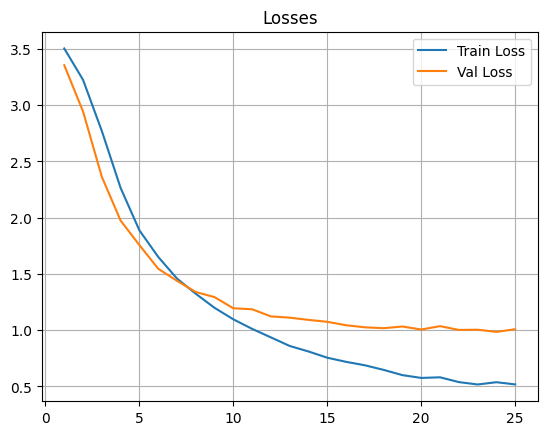

In [ ]:
plt.plot(epochs, rez['train/loss'], label='Train Loss')
plt.plot(epochs, rez['val/loss'], label='Val Loss')
plt.legend()
plt.title("Losses")
plt.grid(True)
plt.show()

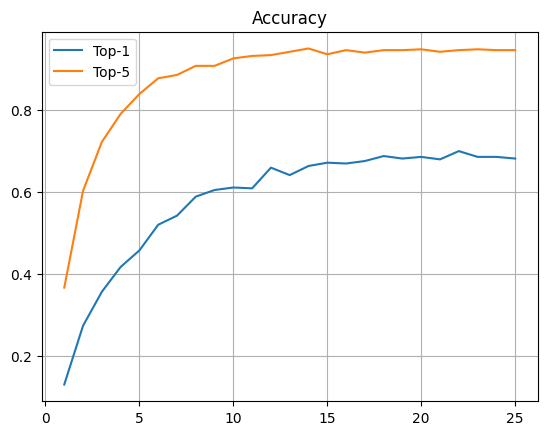

In [ ]:
plt.plot(epochs, rez['metrics/accuracy_top1'], label='Top-1')
plt.plot(epochs, rez['metrics/accuracy_top5'], label='Top-5')
plt.legend(); plt.title("Accuracy"); plt.grid(True); plt.show()

In [ ]:
model = YOLO('/content/runs/classify/insect_cls_yolov8/weights/best.pt') #change the path


image 1/1 /content/dataset/test/Bombus_confusus_Schenck,_1861/image_10.jpg: 320x320 Bombus_confusus_Schenck,_1861 1.00, Bombus_subterraneus_(Linnaeus,_1758) 0.00, Bombus_rupestris_rupestris 0.00, Bombus_vestalis_vestalis 0.00, Bombus_Latreille,_1802 0.00, 3.6ms
Speed: 16.8ms preprocess, 3.6ms inference, 0.1ms postprocess per image at shape (1, 3, 320, 320)


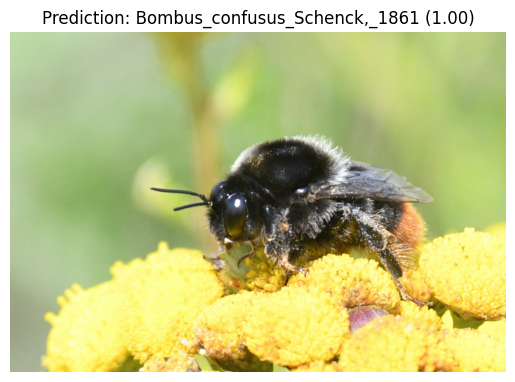

In [ ]:
image_path = "/content/dataset/test/Bombus_confusus_Schenck,_1861/image_10.jpg"  # Change this path

results = model.predict(source=image_path)

from PIL import Image
img = Image.open(image_path)
pred_class = results[0].names[results[0].probs.top1]
confidence = results[0].probs.top1conf

plt.imshow(img)
plt.axis('off')
plt.title(f"Prediction: {pred_class} ({confidence:.2f})")
plt.show()


In [ ]:
from torchvision.datasets import ImageFolder
class CleanImageFolder(ImageFolder):
    def find_classes(self, directory):
        # Ignore hidden folders like `.ipynb_checkpoints`
        classes = [d for d in os.listdir(directory)
                   if os.path.isdir(os.path.join(directory, d)) and not d.startswith('.')]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx

In [ ]:
from PIL import Image
import os

val_dir = os.path.join(dataset_root, "val")

for root, _, files in os.walk(val_dir):
    for file in files:
        path = os.path.join(root, file)
        try:
            img = Image.open(path)
            img.verify()  # Verify the image is ok
        except (IOError, SyntaxError):
            print(f"Removing corrupted image: {path}")
            os.remove(path)


In [ ]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix

In [ ]:
# Add a transform: resize + to tensor
transform = transforms.Compose([
    transforms.Resize((320, 320)),  # Resize to YOLO input size
    transforms.ToTensor()
])

val_dataset = CleanImageFolder(os.path.join(dataset_root, "val"), transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False)

In [ ]:
y_true = []
y_pred = []

for img, label in val_loader:
    # Convert tensor to uint8 NumPy array in shape (H, W, C)
    img_np = (img.squeeze(0).permute(1, 2, 0).numpy() * 255).astype(np.uint8)

    result = model.predict(img_np, verbose=False)[0]
    pred = result.probs.top1

    y_true.append(label.item())
    y_pred.append(pred)

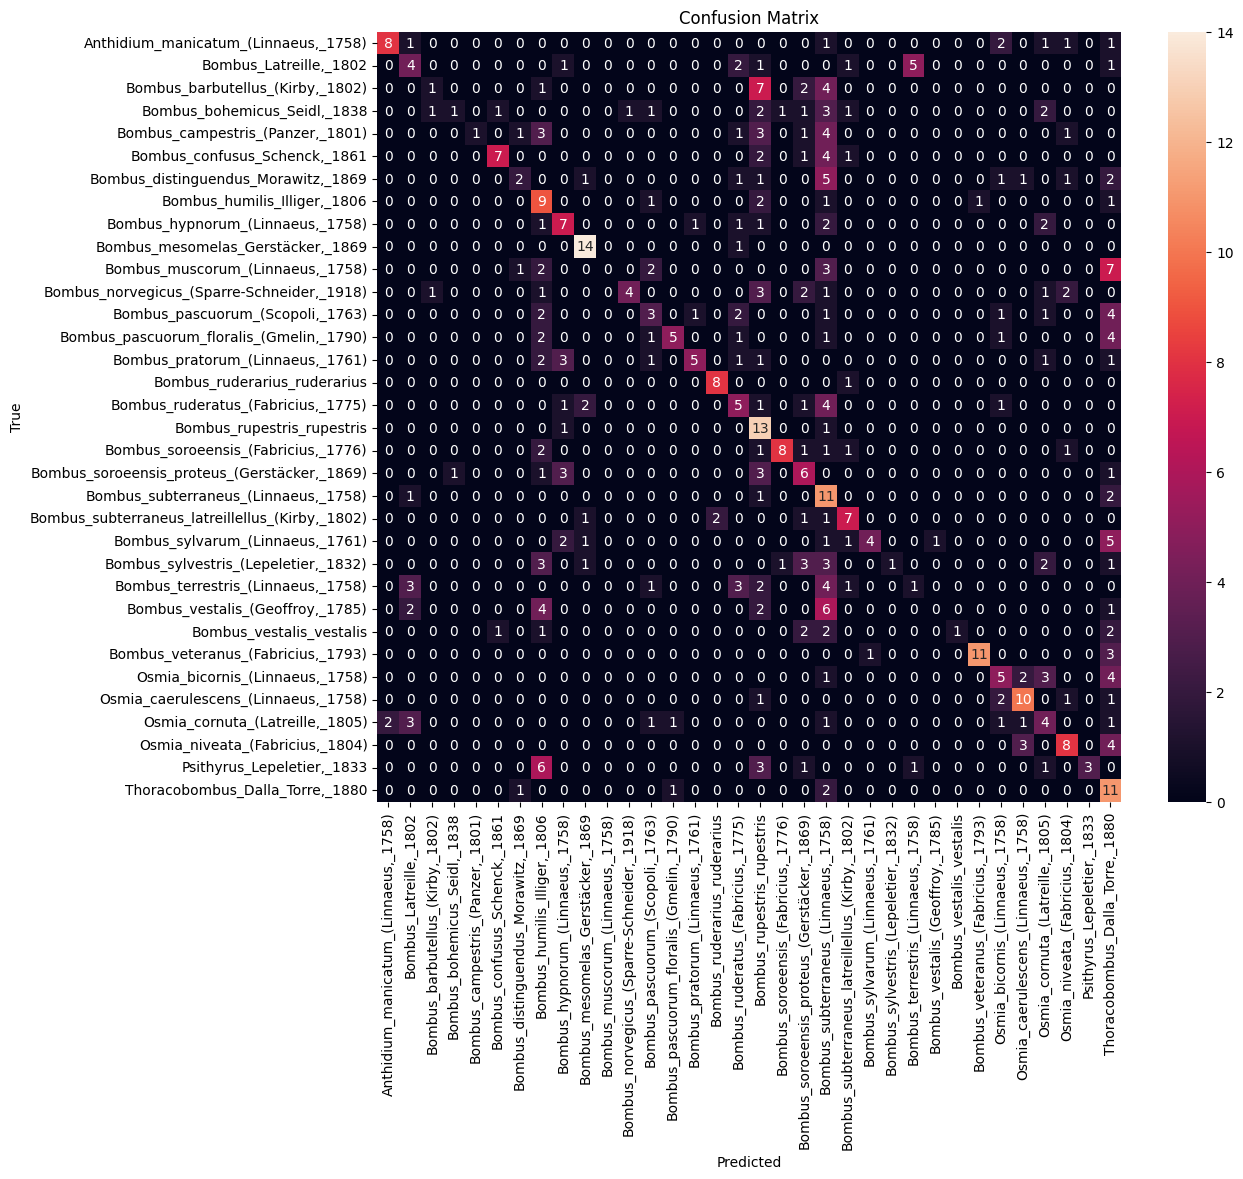

In [ ]:
# Generate and plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=val_dataset.classes, yticklabels=val_dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()